In [1]:
import ROOT
import pandas as pd
import os

In [8]:
def validate_uw_hists(tf,file1,file2,f_path,chi2_dict,n_th1,n_th2,n_tp,errors):  
    """Params based on root file structure -- be sure to change the "==" values based on the length of the path of the root file"""


    # Loop through the available directories or files in the .root file
    for key in tf.GetListOfKeys():

        # Get a handle for the next directory or file
        input = key.ReadObj()
    
        # Determine if the location in the file we are at is a directory
        if issubclass(type(input),ROOT.TDirectoryFile):

            # Record the path of the directory we are looking in
            try:
                f_path = input.GetPath() 
            except:
                print("cant GetPath")

            # Split the path by '/' so we can determine where we are in the folder structure        
            try:
                split_path = f_path.split("/")
            except:
                print('cant split_path')            
            
            
	    # IMPORTANT, these == values will require to be changed based on the length of the path of the root file. In the case of the docker system, /app/etc/etc adds 3 pieces to run/filename for a total length of 5
            # Recursively go deeper into the file structure depending on the length of split_path
            # if len(split_path) == 5:
            if len(split_path) == 2:

                # We are 5 directories deep, go deeper
                f_path,chi2_dict,n_th1,n_th2,n_tp,errors = validate_uw_hists(input,file1, file2,f_path,chi2_dict,n_th1,n_th2,n_tp,errors)  

            # Path lengths greater than the specified number indicate a potential folder of interest from folder_list, check for these and go deeper if so
            # elif len(split_path) > 5 and any(folder in split_path for folder in (folder_list)):                
            elif len(split_path) > 2 and any(folder in split_path for folder in (folder_list)):                
                
		# We are greater than 3 directories deep and these directories include the specified folders above, goo deeper
                f_path,chi2_dict,n_th1,n_th2,n_tp,errors = validate_uw_hists(input,file1, file2,f_path,chi2_dict,n_th1,n_th2,n_tp,errors)     

            
            # If the length is shorter than the specified number, than we need to continue the loop
            else:
                pass
            
            # Record the file_path that will result now that we are done with the current folder level
            # i.e. the folder path that results from going up a level in the directory
            f_path = f_path.split('/')
            f_path = '/'.join(f_path[:-1])
                
        elif issubclass(type(input), ROOT.TProfile):
            # The is a TProfile 

            # Increment the number of TProfiles variable n_tp
            n_tp += 1                
            
            # Record the path of the directory we are looking in with the name of the hist file as part of the path
            try:
                f_path_tp = f_path + '/' + input.GetName()                
            except:
                print("can't get f_path_tp")
            
            # Format f_path_tp
            try:
                # Get the part of f_path that follows the ':'
                f_path_tp = f_path_tp.split(':')
                f_path_tp = f_path_tp[1][1:]
            except:
                print("can't format f_path_tp")
            
            
            # Calculate the chi2 values and store them in chi2_dict
            try:
                # Calculate the chi2 value between file1's and file2's filename:f_name
                chi2ndf_val = file1.Get(f_path_tp).Chi2Test(file2.Get(f_path_tp),'CHI2/NDF')
                chi2_dict['f_name'].append(f_path_tp)
                chi2_dict['f_type'].append('TProfile')
                chi2_dict['chi2ndf_vals'].append(chi2ndf_val)
                print('chi2success')
            except:            
                errors +=1
                print(f'chi2_tp error on filepath: {f_path_th2}')

        
        elif issubclass(type(input),ROOT.TH2):	    
            # The is a TH2 histogram

            # Increment the number of TH2s in variable n_th2
            n_th2 += 1            

            # Record the path of the directory we are looking in with the name of the hist file as part of the path
            try:
                f_path_th2 = f_path + '/' + input.GetName()                
            except:
                print("can't get f_path_th2")
            
            # Format f_path_th2 
            try:
	        # Get the part of f_path that follows the ':'
                f_path_th2 = f_path_th2.split(':')
                f_path_th2 = f_path_th2[1][1:]
            except:
                print("can't format f_path_th2")
            
	    # Calculate the chi2 values and store them in chi2_dict
            try:
                # Calculate the chi2 value between file1's and file2's filename:f_name
                chi2ndf_val = file1.Get(f_path_th2).Chi2Test(file2.Get(f_path_th2),'CHI2/NDF')
                chi2_dict['f_name'].append(f_path_th2)
                chi2_dict['f_type'].append('TH2')
                chi2_dict['chi2ndf_vals'].append(chi2ndf_val)
            except:            
                errors +=1
                print(f'chi2_th2 error on filepath: {f_path_th2}')
                
                
        elif issubclass(type(input),ROOT.TH1):            
            # This is a TH1 histogram

            # Increment the number of TH2s in variable n_th1
            n_th1 += 1
            
            # Record the path of the directory we are looking in with the name of the hist file as part of the path
            try:
                f_path_th1 = f_path + '/' + input.GetName()                
            except:
                print("cant GetPath2")

            # Format f_path_th1
            try:
                # Get the part of f_path that follows the ':'
                f_path_th1 = f_path_th1.split(':')
                f_path_th1 = f_path_th1[1][1:]
            except:
                print("can't format f_path_th1")

            # Calculate the chi2 values and store them in chi2_dict                                    
            try:
                # Calculate the chi2 value between file1's and file2's filename:f_name
                chi2ndf_val = file1.Get(f_path_th1).Chi2Test(file2.Get(f_path_th1),'CHI2/NDF')
                chi2_dict['f_name'].append(f_path_th1)
                chi2_dict['f_type'].append('TH1')
                chi2_dict['chi2ndf_vals'].append(chi2ndf_val)
            except:            
                errors +=1
                print(f'chi2 error on filepath: {f_path_th1}')
            

    return f_path, chi2_dict, n_th1, n_th2,n_tp, errors

In [3]:
def chi2df():

    try:
        with open('/app/data/fileOne.txt', 'r') as f:
            for line in f.readlines():
                if  '' not in line or ' ' not in line or '\n' not in line:
                    file1 = ROOT.TFile.Open("/app/data/" + line)
                    # file1 = ROOT.TFile.Open(line)
    except Exception as e:
        print(f'file1 error: {e}')
        file1 = ROOT.TFile('/app/data/fileOneError.root','RECREATE')

    print('FILE1:',file1)

    try:
        with open('/app/data/fileTwo.txt', 'r') as f:
            for line in f.readlines():
                if  '' not in line or ' ' not in line or '\n' not in line:
                    file2 = ROOT.TFile.Open("/app/data/" + line)
                    # file2 = ROOT.TFile.Open(line)
    except:
        print('file2 sucks')
        file2 = ROOT.TFile.Open('/app/data/fileTwoError.root','RECREATE')
    
    print('FILE2:',file2)

    # To silence the chi2 errors, use the following
    # ROOT.gSystem.RedirectOutput("/dev/null")

    # Calculate the chi2 values and other relevant information for the comparison
    f_path, chi2_dict,n_th1,n_th2,n_tp,errors = validate_uw_hists(file1, file1,file2,'',{'f_name':[],'f_type':[],'chi2ndf_vals':[]},0,0,0,0)

    # Construct the dataframe
    df = pd.DataFrame(chi2_dict)
    
    print('processing complete..')

    return df, errors

In [12]:
# Modified version for standalone
def chi2df(file1_path, file2_path):


    # Get root file1
    try:
        file1 = ROOT.TFile.Open(file1_path)
    except Exception as e:
        print(f'file1 error: {e}')

    print('FILE1:',file1)



    # Get root file2
    try:
        file2 = ROOT.TFile.Open(file2_path)
    except Exception as e:
        print(f'file2 error: {e}')
    
    print('FILE2:',file2)

    # To silence the chi2 errors, use the following
    # ROOT.gSystem.RedirectOutput("/dev/null")

    # Calculate the chi2 values and other relevant information for the comparison
    f_path, chi2_dict,n_th1,n_th2,n_tp,errors = validate_uw_hists(file1, file1,file2,'',{'f_name':[],'f_type':[],'chi2ndf_vals':[]},0,0,0,0)

    # Construct the dataframe
    df = pd.DataFrame(chi2_dict)
    
    print('processing complete..')

    return df, errors

In [10]:
# This list contains the .root directories that you are interested in for the comparison
folder_list = ['CaloMonitoring', 'Jets','MissingEt','Tau','egamma']

In [13]:
file1_path = 'data15_13TeV.00276689.physics_Main.merge.HIST.f1051_h335._0001.1'
file2_path = 'data15_13TeV.00276689.physics_Main.merge.HIST.f1052_h335._0001'
df, errors = chi2df(file1_path, file2_path)

FILE1: Name: data15_13TeV.00276689.physics_Main.merge.HIST.f1051_h335._0001.1 Title: data15_13TeV.00276689.physics_Main.merge.HIST.f1051_h335._0001
FILE2: Name: data15_13TeV.00276689.physics_Main.merge.HIST.f1052_h335._0001 Title: data15_13TeV.00276689.physics_Main.merge.HIST.f1052_h335._0001
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
chi2success
processing complete..


Info in <TProfile2D::Chi2TestX>: There is a bin in h1 with less than 1 event.

Info in <TProfile2D::Chi2TestX>: There is a bin in h2 with less than 1 event.

Info in <TH2F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH2F::Chi2TestX>: There is a bin in h2 with less than 10 effective e

In [7]:
import matplotlib.pyplot as plt

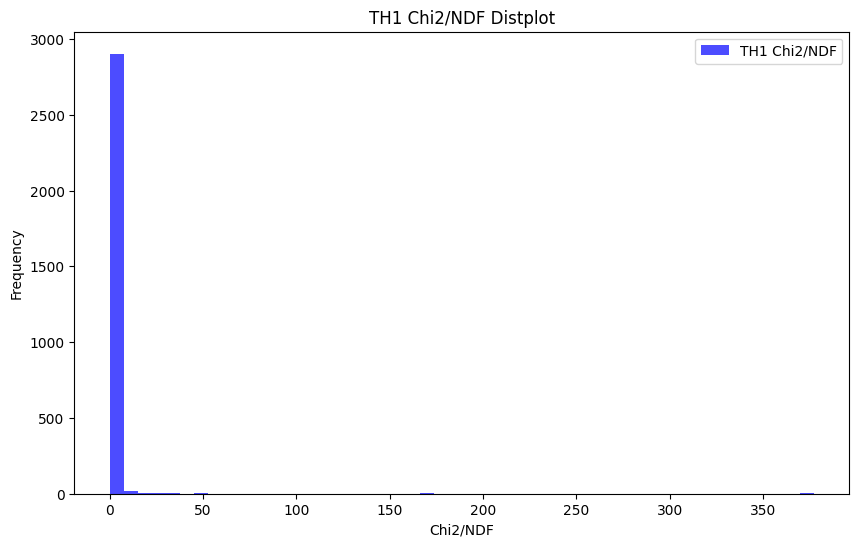

In [14]:
# FOR THE TH1 HISTOGRAMS

df_th1s = df[df['f_type']=='TH1']
hist_data = [df_th1s['chi2ndf_vals'].values]    

# Make hist_data distplot
plt.figure(figsize=(10,6))
plt.hist(hist_data, bins=50, alpha=0.7, color='b', label='TH1 Chi2/NDF')
plt.xlabel('Chi2/NDF')
plt.ylabel('Frequency')
plt.title('TH1 Chi2/NDF Distplot')
plt.legend(loc='upper right')
plt.show()

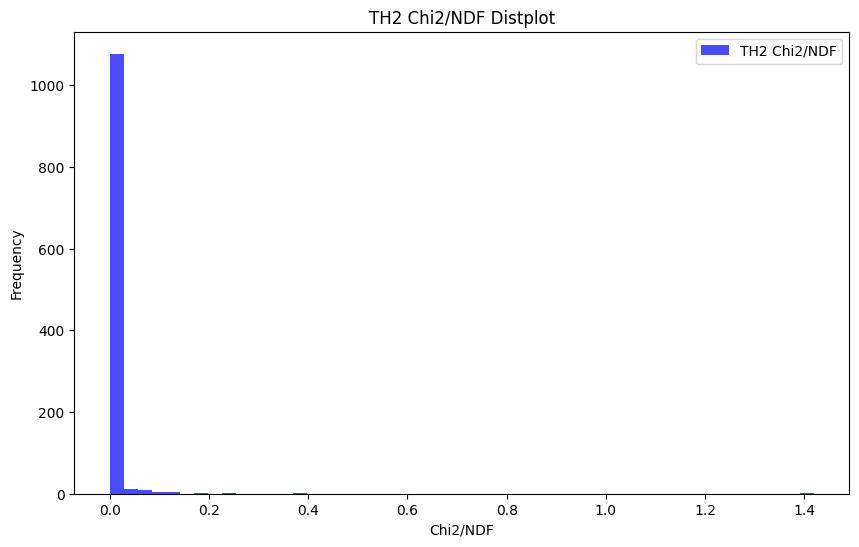

In [15]:
# FOR THE TH2 HISTOGRAMS

df_th2s = df[df['f_type']=='TH2']
hist_data = [df_th2s['chi2ndf_vals'].values]    

plt.figure(figsize=(10,6))
plt.hist(hist_data, bins=50, alpha=0.7, color='b', label='TH2 Chi2/NDF')
plt.xlabel('Chi2/NDF')
plt.ylabel('Frequency')
plt.title('TH2 Chi2/NDF Distplot')
plt.legend(loc='upper right')
plt.show()

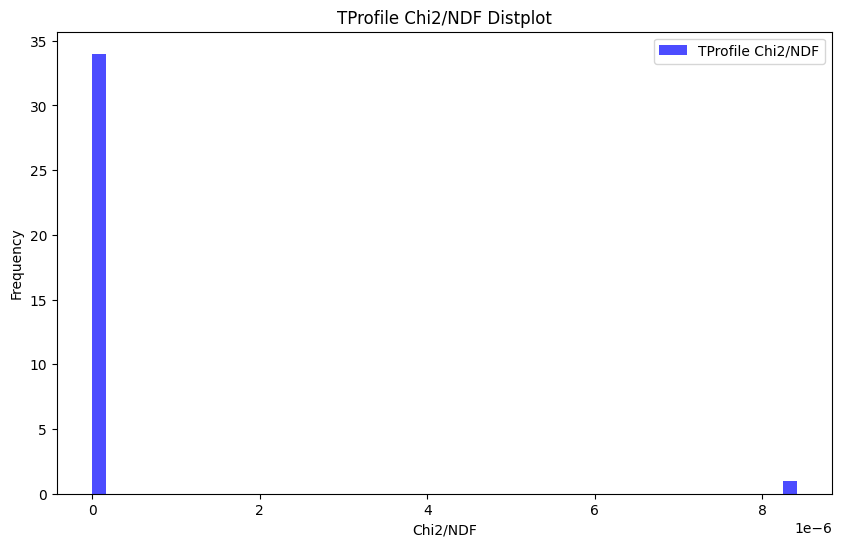

In [16]:
# TProfile HISTOGRAMS

df_tp = df[df['f_type']=='TProfile']
hist_data = [df_tp['chi2ndf_vals'].values]    

plt.figure(figsize=(10,6))
plt.hist(hist_data, bins=50, alpha=0.7, color='b', label='TProfile Chi2/NDF')
plt.xlabel('Chi2/NDF')
plt.ylabel('Frequency')
plt.title('TProfile Chi2/NDF Distplot')
plt.legend(loc='upper right')
plt.show()

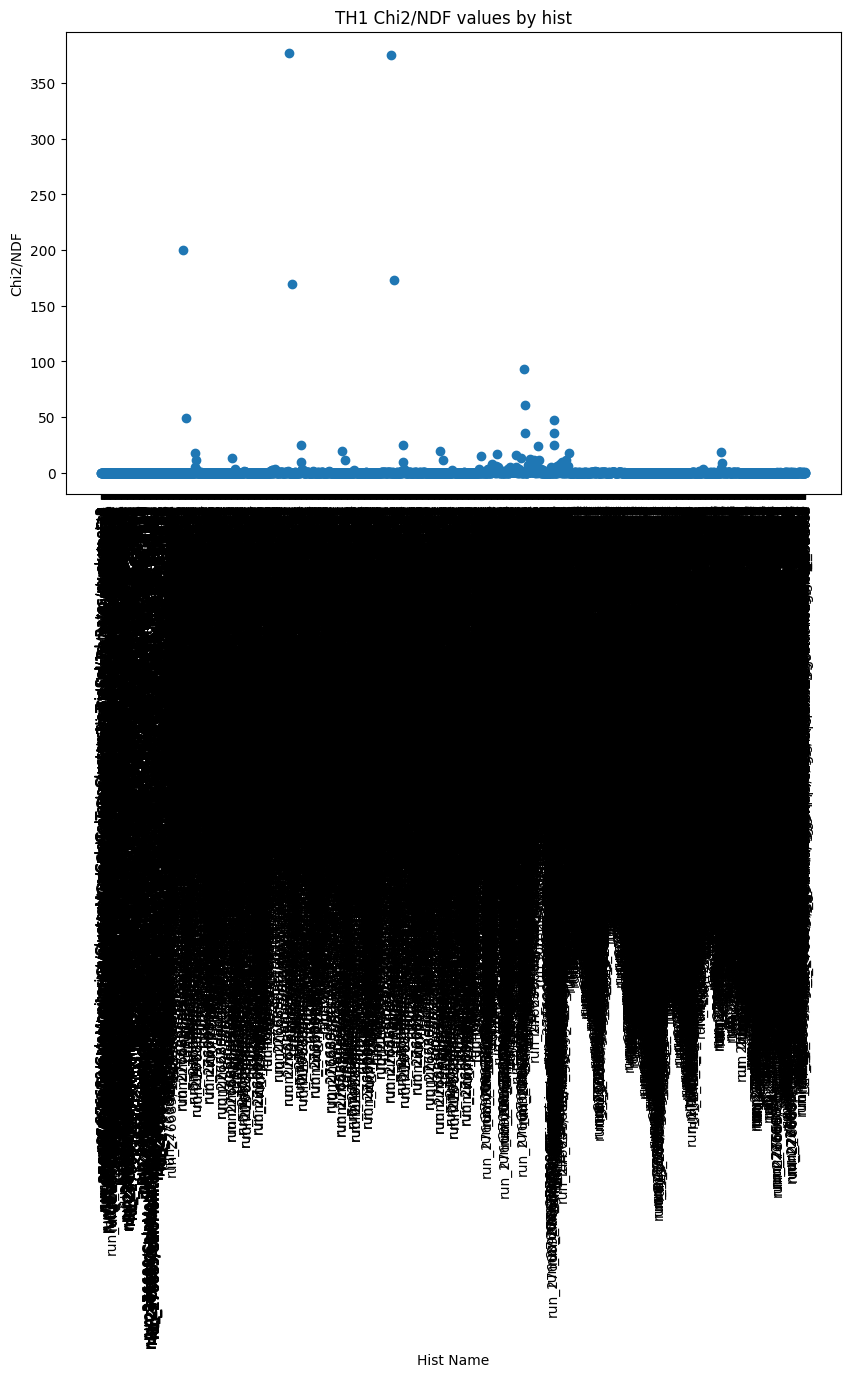

In [17]:
df_th1s = df[df['f_type']=='TH1']

plt.figure(figsize=(10,6))
plt.scatter(df_th1s['f_name'],df_th1s['chi2ndf_vals'])
plt.xlabel('Hist Name')
plt.ylabel('Chi2/NDF')
plt.title('TH1 Chi2/NDF values by hist')
plt.xticks(rotation=90)
plt.show()

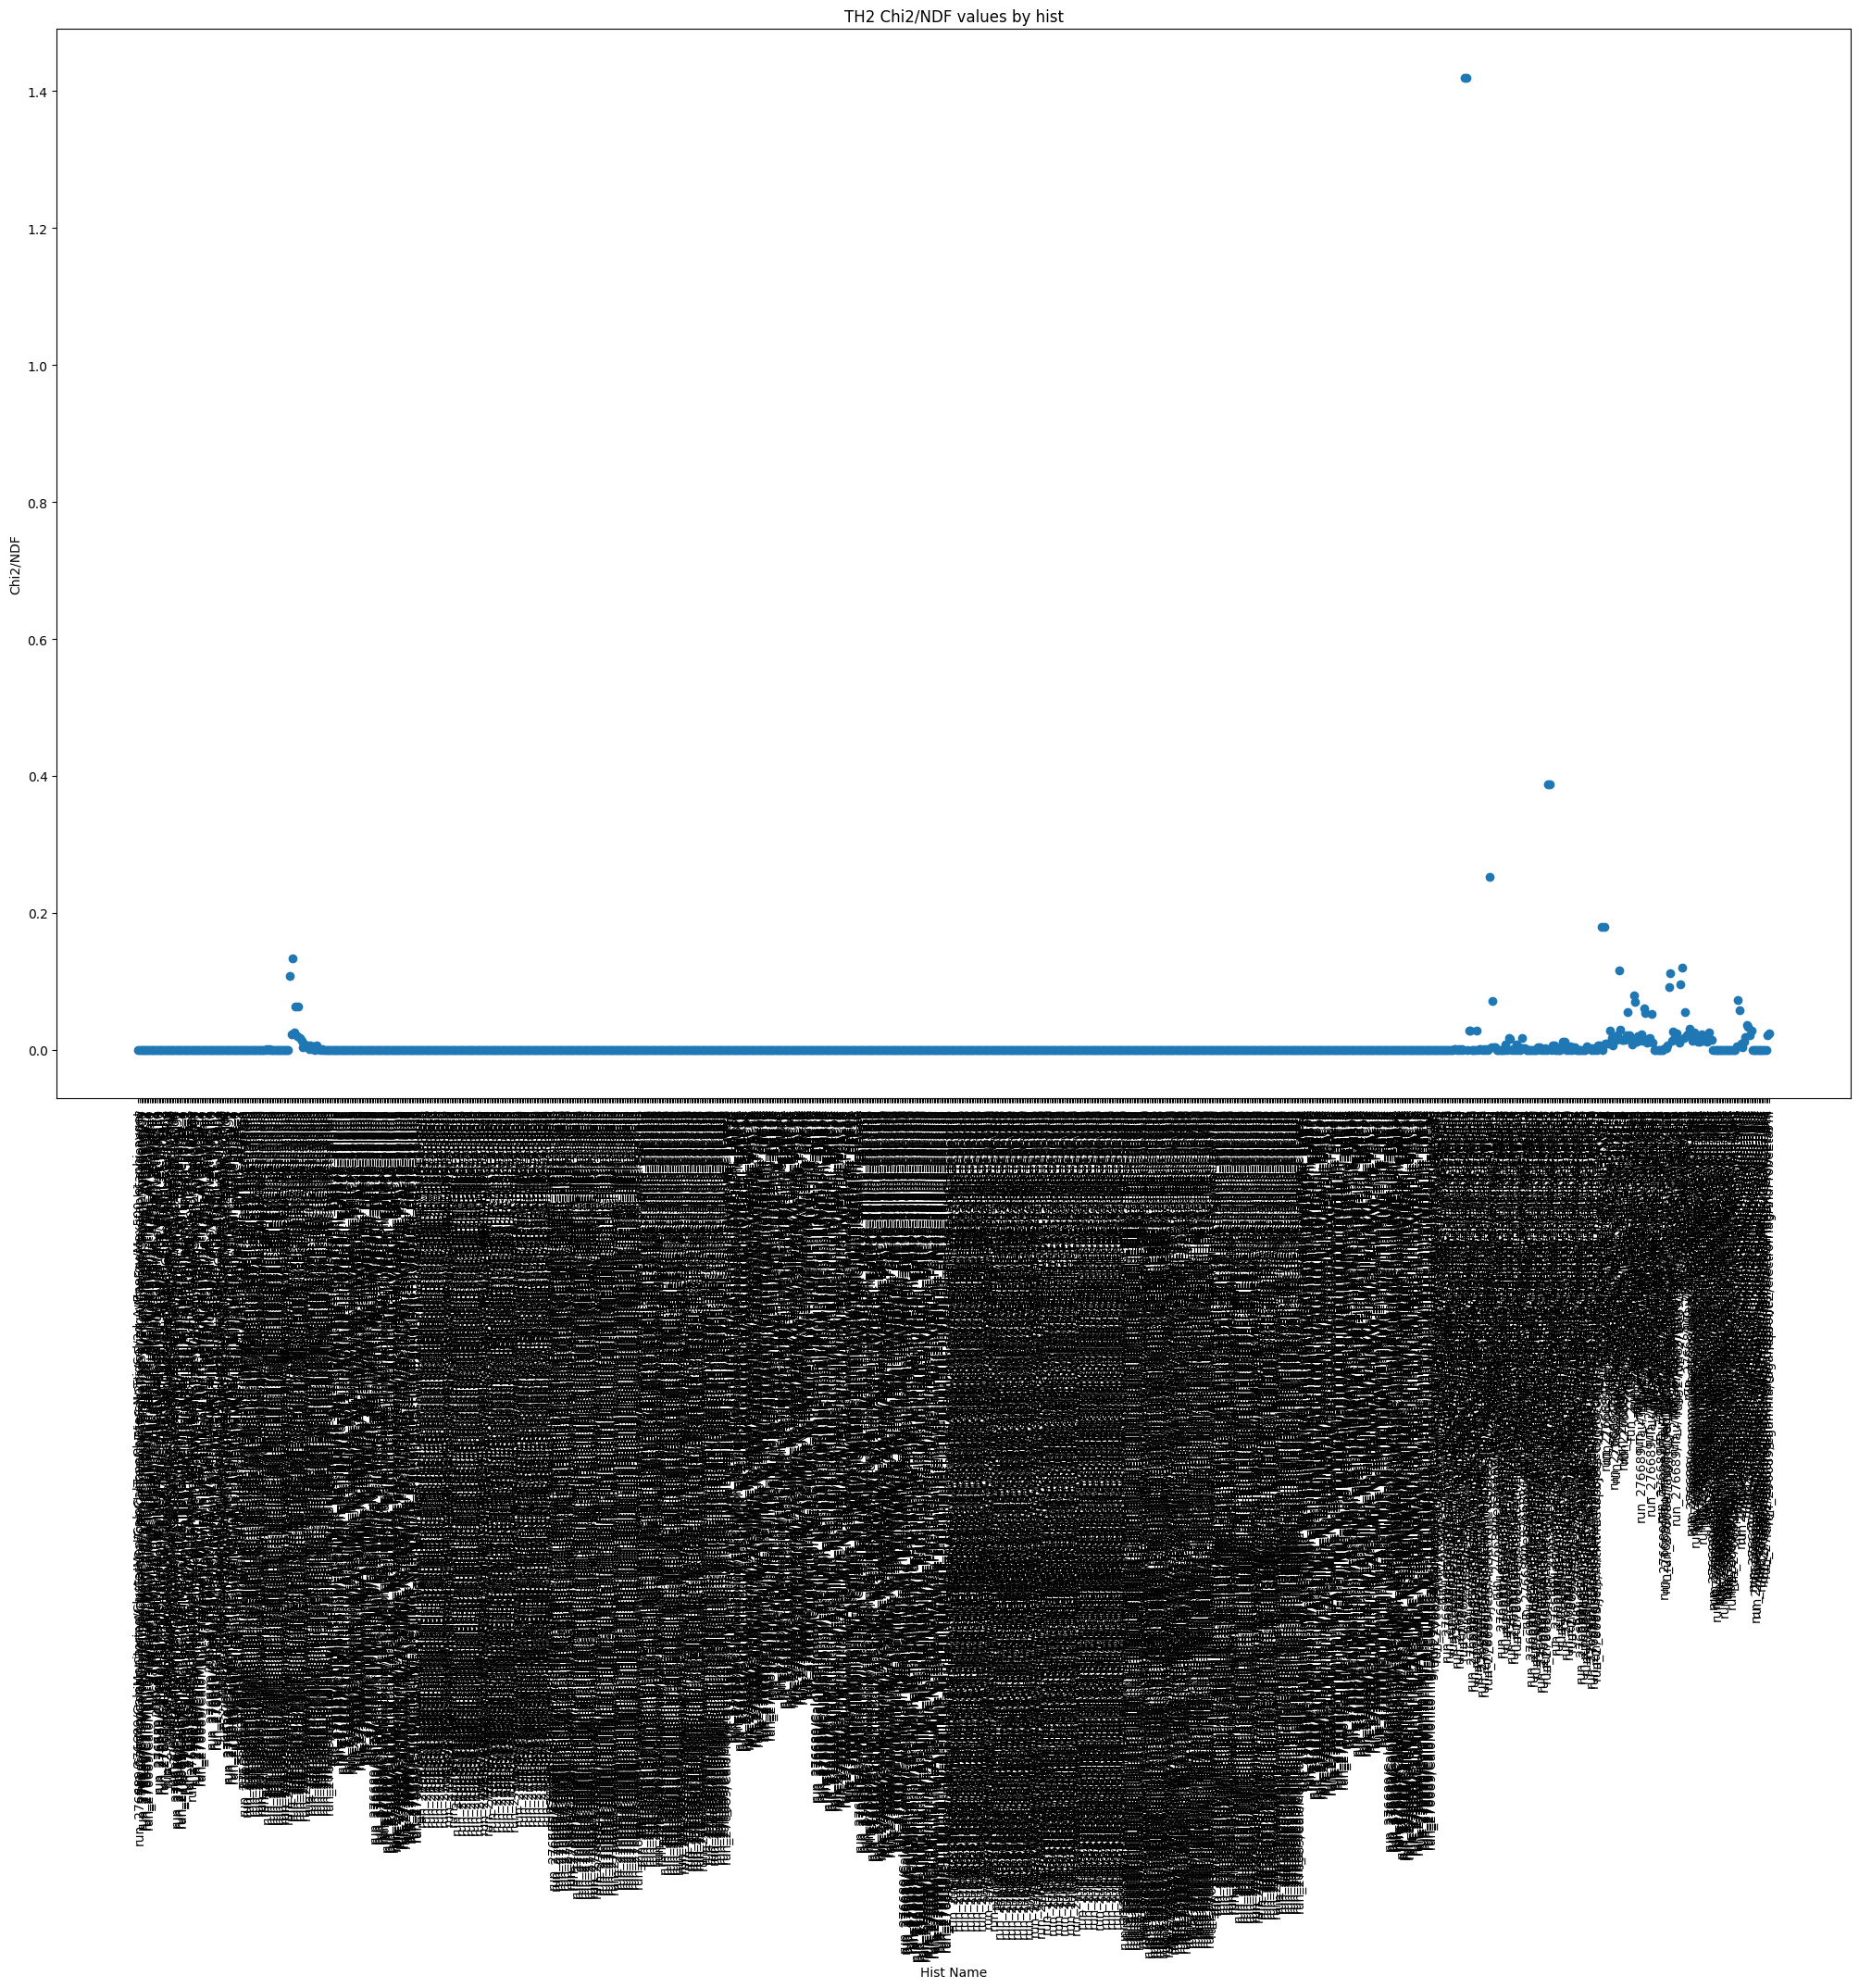

In [20]:
df_th2s = df[df['f_type']=='TH2']

plt.figure(figsize=(25,15))
plt.scatter(df_th2s['f_name'],df_th2s['chi2ndf_vals'])
plt.xlabel('Hist Name')
plt.ylabel('Chi2/NDF')
plt.title('TH2 Chi2/NDF values by hist')
plt.xticks(rotation=90)
plt.show()

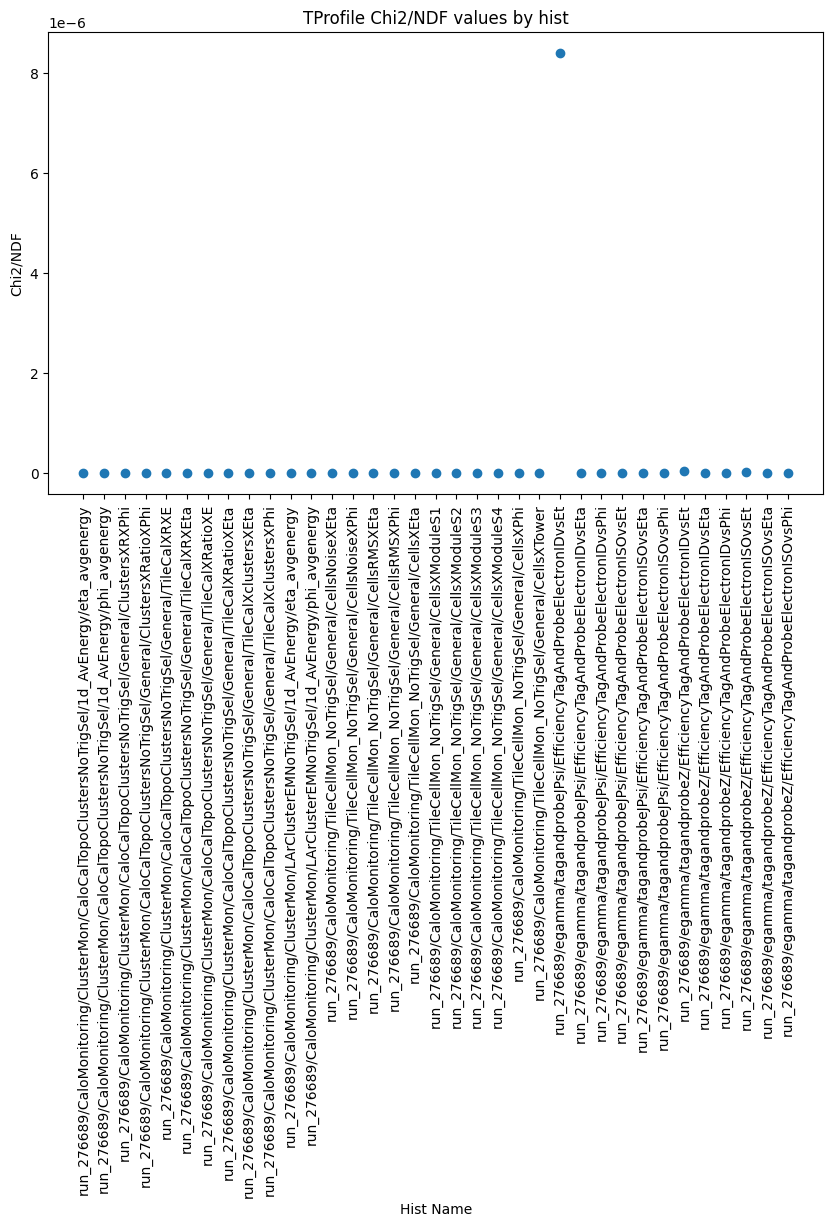

In [19]:
df_tp = df[df['f_type']=='TProfile']

plt.figure(figsize=(10,6))
plt.scatter(df_tp['f_name'],df_tp['chi2ndf_vals'])
plt.xlabel('Hist Name')
plt.ylabel('Chi2/NDF')
plt.title('TProfile Chi2/NDF values by hist')
plt.xticks(rotation=90)
plt.show()